**Predicting IDC in Breast Cancer Histology Images** ~ Paul Mooney, November 2017.

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer.  Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

The goal of this script is to identify IDC when it is present in otherwise unlabeled histopathology images.  The dataset consists of approximately five thousand 50x50 pixel RGB digital images of H&E-stained breast histopathology samples that are labeled as either IDC or non-IDC. These numpy arrays are small patches that were extracted from digital images of breast tissue samples.  The breast tissue contains many cells but only some of them are cancerous.  Patches that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma.  For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

For more information about IDC and breast cancer, please review the following publications: 
* https://www.ncbi.nlm.nih.gov/pubmed/27864452
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3893344/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4952020/

*Step 1: Import Modules*

In [21]:
import numpy as np
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

*Step 2: Load Data*

In [23]:
X = np.load('../input/X.npy') # images
Y = np.load('../input/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

*Step 3: Describe Data*

In [3]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


*Step 4: Plot Data*

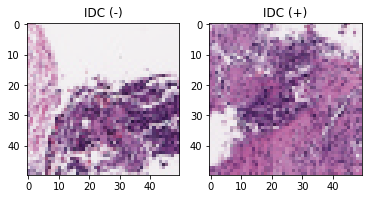

In [4]:
imgs0 = X[Y==0] # (0 = no IDC, 1 = IDC)
imgs1 = X[Y==1] 

def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 


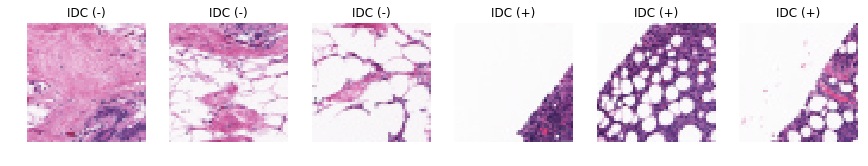

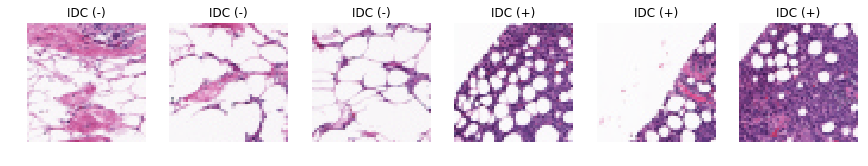

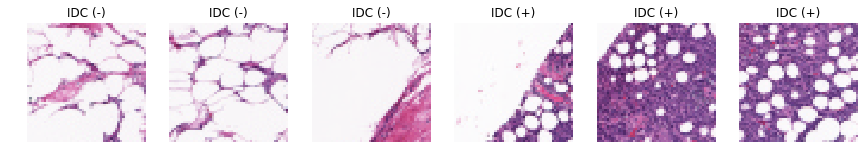

In [5]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 


*Step 4: Preprocess Data*

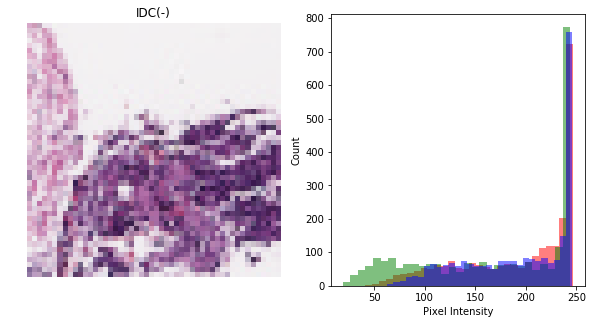

In [6]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[100])

The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1.  This will make the data compatible with a wide variety of different classification algorithms.

We also want to set aside 20% of the data for k-fold cross-validation testing.  This will make the trained model less prone to overfitting.

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)


Training Data Shape: (4437, 50, 50, 3) (4437, 50, 50, 3)
Testing Data Shape: (1110, 50, 50, 3) (1110, 50, 50, 3)


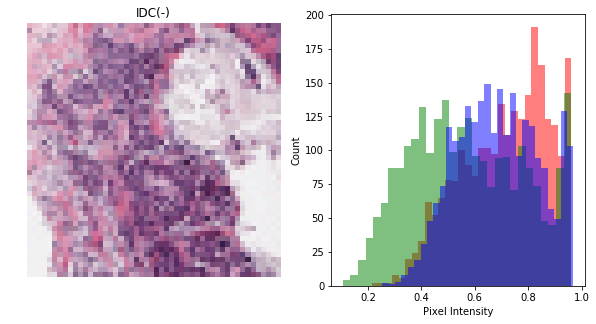

In [8]:
plotHistogram(X_train[100])

Now the data is scaled from 0 to 1.

Next we can try using some standard classification algorithms to predict whether or not IDC is present in each given sample.

*Step 5: Evaluate Classification Algorithms*

In [9]:
# Make Data 1D for compatability with standard classifiers

X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [10]:
#runLogisticRegression
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

LogisticRegression - Training set accuracy: 0.700900900901 (0.0455467555307)




Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.700901 (0.045547)
RF: 0.740541 (0.035308)
KNN: 0.731532 (0.050128)
SVM: 0.754054 (0.040500)
LSVM: 0.675676 (0.049998)
GNB: 0.737838 (0.034293)
DTC: 0.670270 (0.045261)


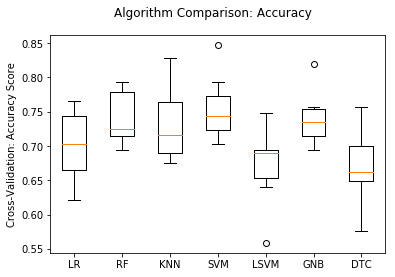


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier



In [11]:
# Compare Performance of Classification Algorithms
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    #models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)


def defineModels():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('')
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    #print('GBC = GradientBoostingClassifier')
    #print('LDA = LinearDiscriminantAnalysis')
    print('')
    return
defineModels()

With the Support Vector Machine we are getting ~75% accuracy. Next I will plot a confusion matrix for the results that were produced by the Support Vector Machine in order to verify that we do not have too many false positives.


Support Vector Machine - Training set accuracy: 0.754054054054 (0.0405004807081) 



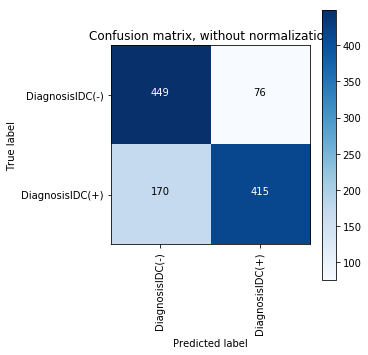

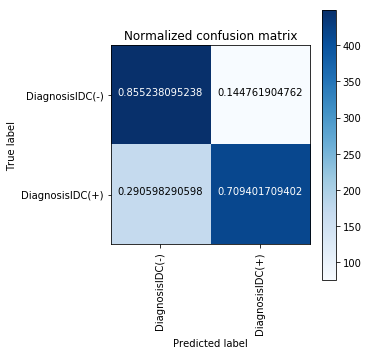

In [13]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """Run SVC w/ Kfold CV + Confusion Matrix"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["Diagnosis" "IDC(-)", "Diagnosis" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)

Here in these confusion plots the Y-Axis represents the True labels ["IDC(-)" or "IDC(+)"] while the X-Axis represents the Predicted labels (generated by the Support Vector Machine).  Ideally, the predicted labels will be the same as the idea labels.  This is actually pretty good! 

But we should be able to improve our score by using neural networks.  Next I will use the original 2-D data and I will try to solve this classification problem by using 2D convolutional neural networks.

In [25]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [18]:
# Special callback to see learning curves
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')


Train on 4437 samples, validate on 1110 samples
Epoch 1/12
4437/4437 [==============================] - 54s 12ms/step - loss: 0.7576 - acc: 0.5538 - val_loss: 0.6545 - val_acc: 0.6559
Epoch 2/12
4437/4437 [==============================] - 53s 12ms/step - loss: 0.6578 - acc: 0.6135 - val_loss: 0.6409 - val_acc: 0.6261
Epoch 3/12
4437/4437 [==============================] - 51s 12ms/step - loss: 0.6461 - acc: 0.6504 - val_loss: 0.6414 - val_acc: 0.6279
Epoch 4/12
4437/4437 [==============================] - 52s 12ms/step - loss: 0.6287 - acc: 0.6631 - val_loss: 0.5909 - val_acc: 0.7027
Epoch 5/12
4437/4437 [==============================] - 52s 12ms/step - loss: 0.6045 - acc: 0.6989 - val_loss: 0.5693 - val_acc: 0.7135
Epoch 6/12
4437/4437 [==============================] - 52s 12ms/step - loss: 0.6081 - acc: 0.6802 - val_loss: 0.6525 - val_acc: 0.6126
Epoch 7/12
4437/4437 [==============================] - 52s 12ms/step - loss: 0.5944 - acc: 0.7045 - val_loss: 0.5733 - val_acc: 0.7216


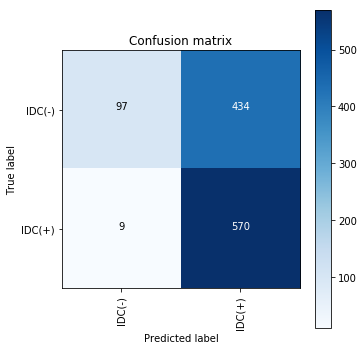

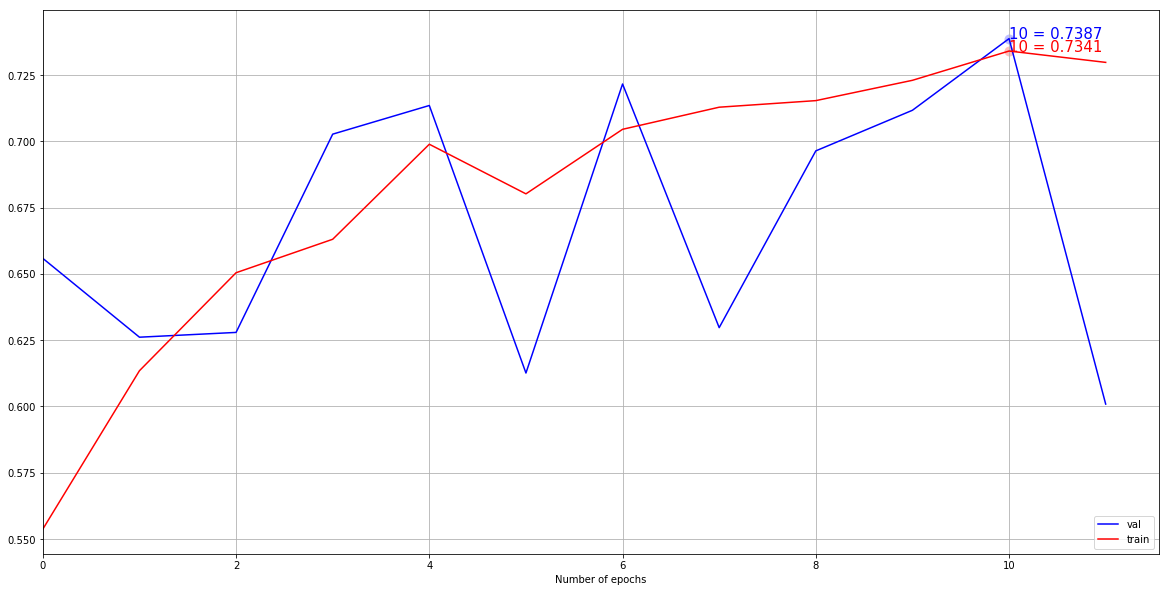

In [27]:
def runKerasCNN(a,b,c,d):
    """
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 12  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN #1A - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
runKerasCNN(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

The confusion matrix illustrates that this model is predicting IDC(+) far too often and the learning curve illustrates that the validation score is consistently less than the traning score.  Together, these results suggest that our model suffers from high bias.

I will try using different artificial neural network.


Train on 4437 samples, validate on 1110 samples
Epoch 1/12
4437/4437 [==============================] - 94s 21ms/step - loss: 1.9712 - acc: 0.6705 - val_loss: 0.6898 - val_acc: 0.4784
Epoch 2/12
4437/4437 [==============================] - 93s 21ms/step - loss: 0.5716 - acc: 0.7352 - val_loss: 0.6533 - val_acc: 0.6838
Epoch 3/12
4437/4437 [==============================] - 93s 21ms/step - loss: 0.5569 - acc: 0.7496 - val_loss: 0.6502 - val_acc: 0.5856
Epoch 4/12
4437/4437 [==============================] - 93s 21ms/step - loss: 0.5295 - acc: 0.7721 - val_loss: 0.6059 - val_acc: 0.6730
Epoch 5/12
4437/4437 [==============================] - 96s 22ms/step - loss: 0.5188 - acc: 0.7712 - val_loss: 1.0136 - val_acc: 0.5297
Epoch 6/12
4437/4437 [==============================] - 96s 22ms/step - loss: 0.5166 - acc: 0.7744 - val_loss: 0.6103 - val_acc: 0.6694
Epoch 7/12
4437/4437 [==============================] - 93s 21ms/step - loss: 0.5179 - acc: 0.7730 - val_loss: 0.6642 - val_acc: 0.5225


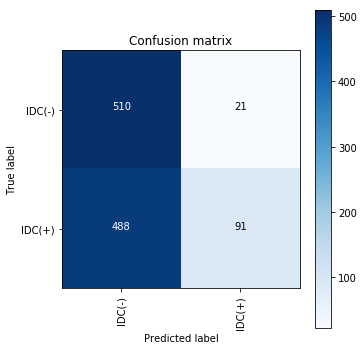

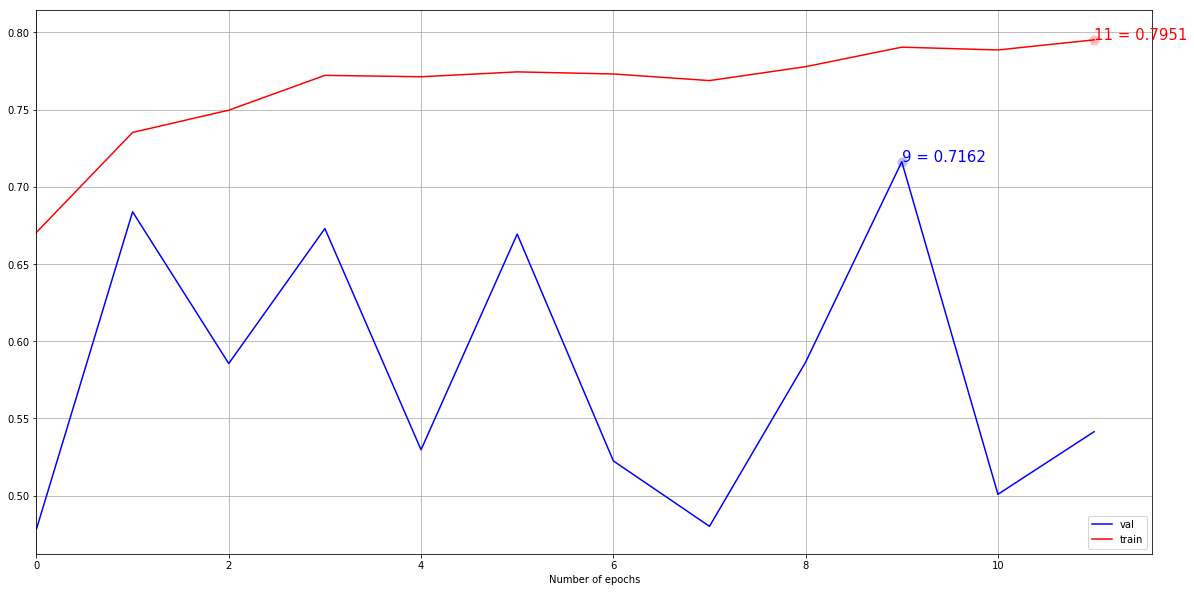

In [29]:
def runAnotherKeras(a, b,c,d):
    # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out   
    batch_size = 128
    num_classes = 2
    epochs = 12
    # input image dimensions
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    model.fit(a,b,
                  batch_size=batch_size,
                  verbose=1,
                  epochs=epochs,
                  validation_data=(c,d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
runAnotherKeras(X_train, Y_train, X_test, Y_test)
plotKerasLearningCurve()

The confusion matrix illustrates that this model is predicting IDC(-) far too often and the learning curve illustrates that the validation score is consistently less than the traning score.  Together, these results suggest that our model suffers from high bias.

I will try using another network architecture and I will also include a data augmentation step in our to try to decrease the bias in our model.

Epoch 1/12
139/138 [==============================] - 124s 895ms/step - loss: 0.6754 - acc: 0.5639 - val_loss: 0.6423 - val_acc: 0.6550
Epoch 2/12
139/138 [==============================] - 123s 888ms/step - loss: 0.6338 - acc: 0.6550 - val_loss: 0.6310 - val_acc: 0.6712
Epoch 3/12
139/138 [==============================] - 122s 878ms/step - loss: 0.6135 - acc: 0.6769 - val_loss: 0.6700 - val_acc: 0.5414
Epoch 4/12
139/138 [==============================] - 123s 887ms/step - loss: 0.6039 - acc: 0.6967 - val_loss: 0.6022 - val_acc: 0.6631
Epoch 5/12
139/138 [==============================] - 123s 887ms/step - loss: 0.5934 - acc: 0.7039 - val_loss: 0.5853 - val_acc: 0.7288
Epoch 6/12
139/138 [==============================] - 121s 874ms/step - loss: 0.5867 - acc: 0.7149 - val_loss: 0.5637 - val_acc: 0.7225
Epoch 7/12
139/138 [==============================] - 124s 891ms/step - loss: 0.5610 - acc: 0.7257 - val_loss: 0.8718 - val_acc: 0.5324
Epoch 8/12
139/138 [============================

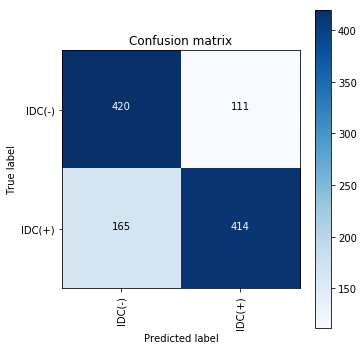

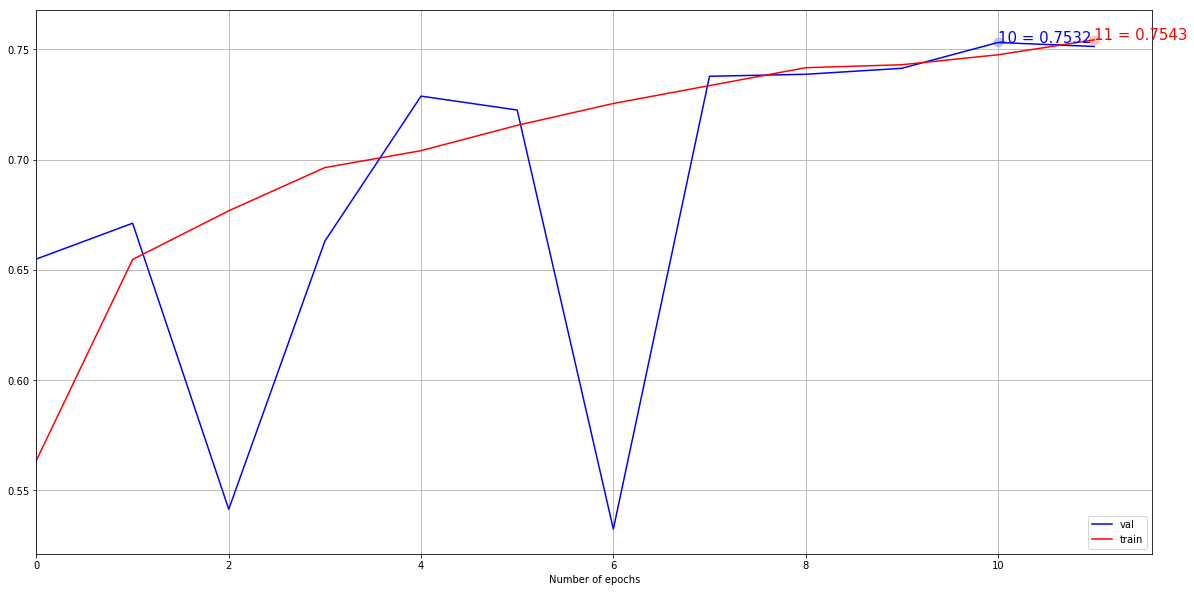

In [30]:
def kerasAugmentation(a,b,c,d):
    img_rows, img_cols = 50,50
    input_shape = (img_rows, img_cols, 3)
    batch_size = 128
    num_classes = 2
    epochs = 12
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #3B - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
kerasAugmentation(X_train, Y_train, X_test, Y_test)
plotKerasLearningCurve()

This is our best result yet.  75% accuracy and a distribution of predicted labels that is similar to the distribtion of actual labels (50/50).  I think that the data augmentation step definitely helped, but I am still a little bit worried about high bias in our model given the variation between the training score and cross validation score.

I will try another model now where I change the network architecture but retain the data augmentation step.

Epoch 1/16
139/138 [==============================] - 110s 794ms/step - loss: 1.0596 - acc: 0.6756 - val_loss: 0.6245 - val_acc: 0.6820
Epoch 2/16
139/138 [==============================] - 109s 784ms/step - loss: 0.5933 - acc: 0.7180 - val_loss: 0.8581 - val_acc: 0.5613
Epoch 3/16
139/138 [==============================] - 107s 773ms/step - loss: 0.5601 - acc: 0.7349 - val_loss: 6.8888 - val_acc: 0.5045
Epoch 4/16
139/138 [==============================] - 108s 779ms/step - loss: 0.5544 - acc: 0.7516 - val_loss: 1.1190 - val_acc: 0.6495
Epoch 5/16
139/138 [==============================] - 108s 779ms/step - loss: 0.5490 - acc: 0.7528 - val_loss: 0.7703 - val_acc: 0.6703
Epoch 6/16
139/138 [==============================] - 106s 760ms/step - loss: 0.5507 - acc: 0.7538 - val_loss: 5.6660 - val_acc: 0.5189
Epoch 7/16
139/138 [==============================] - 105s 755ms/step - loss: 0.5442 - acc: 0.7551 - val_loss: 0.7767 - val_acc: 0.6559
Epoch 8/16
139/138 [============================

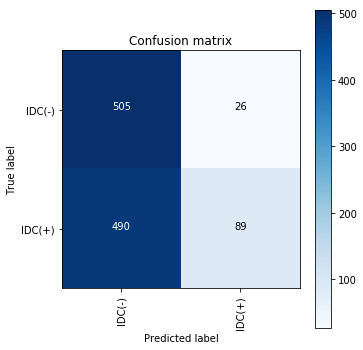

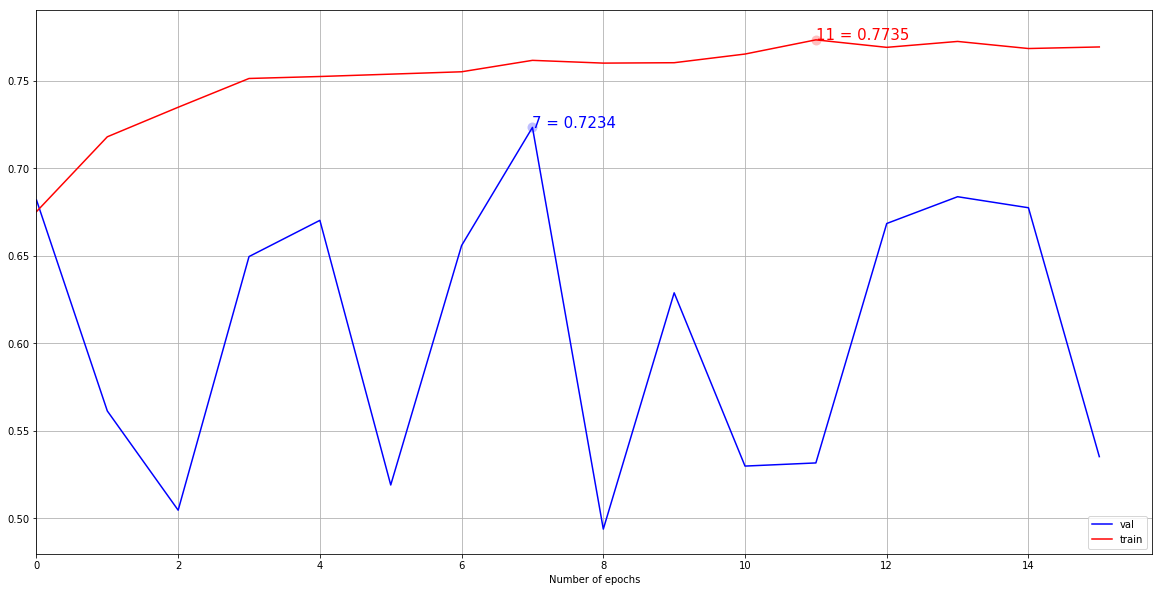

In [33]:
def runAnotherKerasAugmentedConfusion(a,b,c,d):
    # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out 
    batch_size = 128
    num_classes = 2
    epochs = 16
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential() 
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
runAnotherKerasAugmentedConfusion(X_train, Y_train, X_test, Y_test)   
plotKerasLearningCurve()

The confusion matrix illustrates that this model is predicting IDC(-) far too often and the learning curve illustrates that the validation score is consistently less than the traning score.  Together, these results suggest that our model suffers from high bias despite containing a data augmentation step.

I will try using another network architecture.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 46, 46, 32)        2432      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 11, 11, 32)        25632     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                18496     
__________

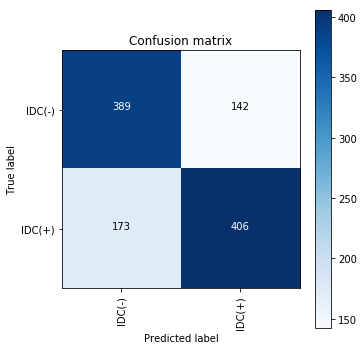

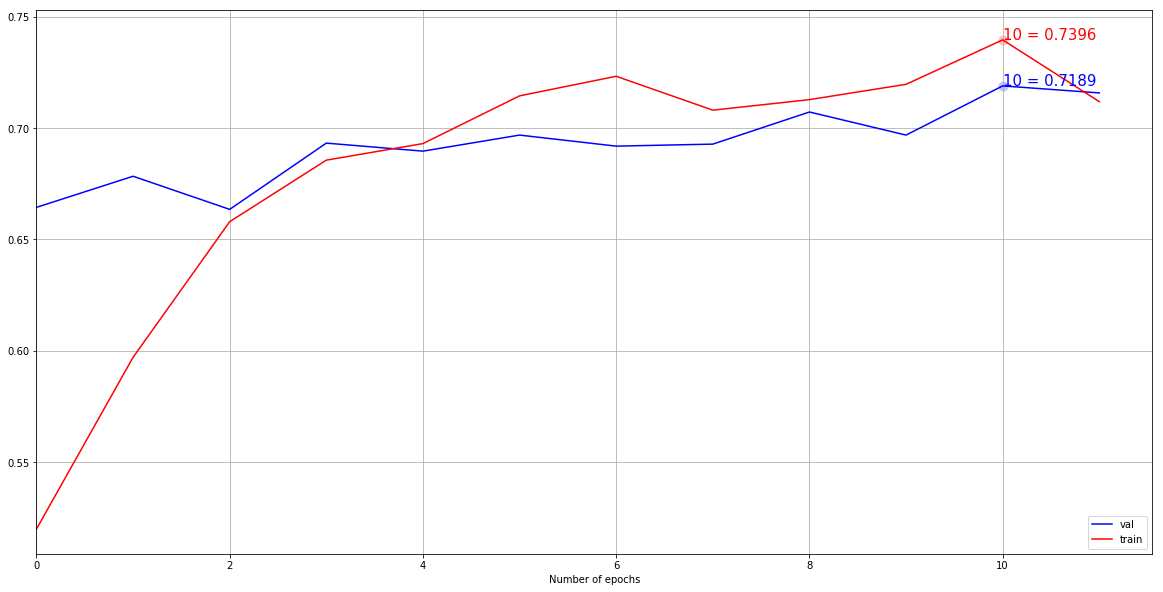

In [36]:
# Create the model
def yetAnotherKeras(a,b,c,d):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(50, 50, 3))) # first layer : convolution
    model.add(MaxPooling2D(pool_size=(3, 3))) # second layer : pooling (reduce the size of the image per 3) 
    model.add(Conv2D(32, (5, 5), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid')) # output 1 value between 0 and 1 : probability to have cancer
    model.summary()
    model.compile(loss=keras.losses.binary_crossentropy, # Use binary crossentropy as a loss function  
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    model.fit(a,b,
              batch_size=128,
              epochs=12,
              verbose=1,
              validation_data = [c,d],
            callbacks = [MetricsCheckpoint('logs')])
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
yetAnotherKeras(X_train,Y_train,X_test,Y_test)
plotKerasLearningCurve()

This is a decent result.  73% accuracy is just slightly less accurate than our most accurate model yet.  The learning curve here suggests that our model does not have too much bias.  If anything, the model may be overfitting a bit, given the close relationship between the training and validation scores.

I will try using a different network architecture and once again I will also include a data augmentation step.

Epoch 1/12
139/138 [==============================] - 61s 438ms/step - loss: 0.6586 - acc: 0.6358 - val_loss: 0.5944 - val_acc: 0.6982
Epoch 2/12
139/138 [==============================] - 61s 439ms/step - loss: 0.5983 - acc: 0.7036 - val_loss: 0.6431 - val_acc: 0.6486
Epoch 3/12
139/138 [==============================] - 60s 435ms/step - loss: 0.5757 - acc: 0.7159 - val_loss: 0.5688 - val_acc: 0.7144
Epoch 4/12
139/138 [==============================] - 61s 439ms/step - loss: 0.5554 - acc: 0.7334 - val_loss: 0.5307 - val_acc: 0.7414
Epoch 5/12
139/138 [==============================] - 60s 433ms/step - loss: 0.5428 - acc: 0.7395 - val_loss: 0.5299 - val_acc: 0.7450
Epoch 6/12
139/138 [==============================] - 60s 432ms/step - loss: 0.5390 - acc: 0.7498 - val_loss: 0.5248 - val_acc: 0.7450
Epoch 7/12
139/138 [==============================] - 60s 433ms/step - loss: 0.5310 - acc: 0.7509 - val_loss: 0.5580 - val_acc: 0.7396
Epoch 8/12
139/138 [==============================] - 6

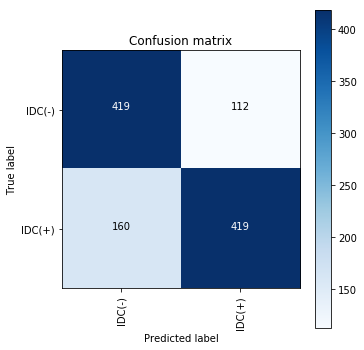

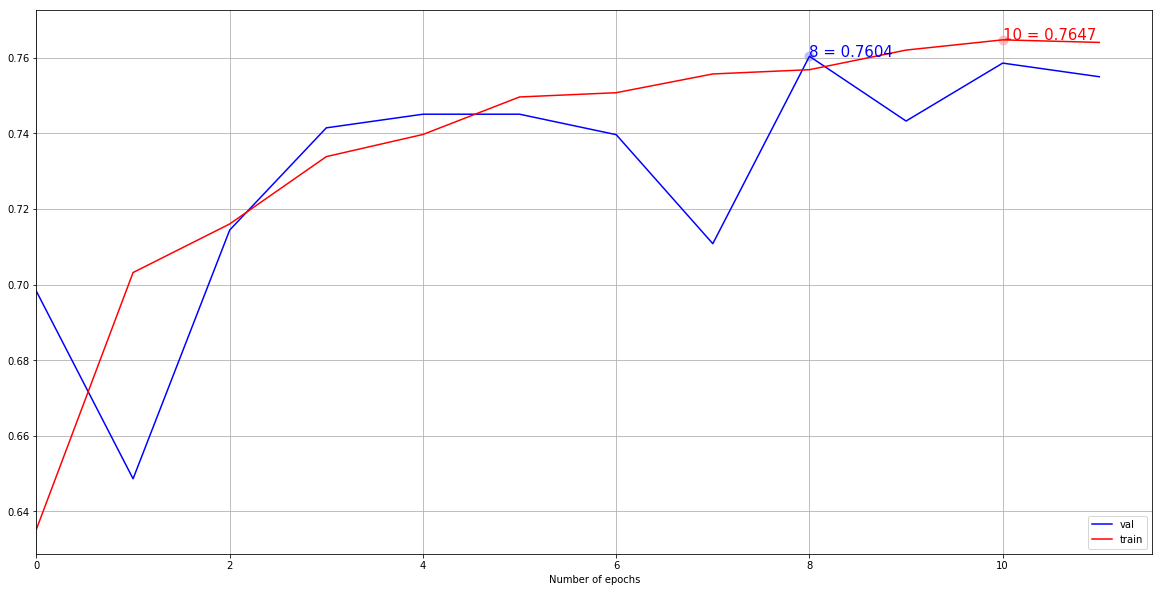

In [34]:
def runKerasCNNAugment(a,b,c,d):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 12
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    score = model.evaluate(x_test, y_test, verbose=0)
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
runKerasCNNAugment(X_train, Y_train,  X_test, Y_test)
plotKerasLearningCurve()

This is our best result yet.  76% accuracy and a distribution of predicted labels that is similar to the distribtion of actual labels (50/50).   The learning curve suggests that there is not too much overfitting given the different shapes of the training and cross-validation curves, and both the confusion matrix and the learning curve suggest that the model does not have high bias.  But with only two categories (IDC negative/IDC plus), we should hope to do better than 80% accuracy.  Soon I will experiment with different data augmentation approaches in an attempt to improve our model's accuracy. In the future, tools like this can be used to save time, cut costs, and increase the accuracy of imaging-based diagnostic approaches in the healthcare industry. 

To Do:
1) Improve data visualization
2) Optimize data augmentation
3) Optimize NN architecture